<h1>Определение перспективного тарифа для телеком-компании<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Извлечение-данных" data-toc-modified-id="Извлечение-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Извлечение данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Устранение-ошибок/дубликатов" data-toc-modified-id="Устранение-ошибок/дубликатов-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Устранение ошибок/дубликатов</a></span></li><li><span><a href="#Создание-сводной-таблицы-расходов-пользователя" data-toc-modified-id="Создание-сводной-таблицы-расходов-пользователя-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Создание сводной таблицы расходов пользователя</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Интернет" data-toc-modified-id="Интернет-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Интернет</a></span></li><li><span><a href="#Сообщения" data-toc-modified-id="Сообщения-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Сообщения</a></span></li><li><span><a href="#Звонки" data-toc-modified-id="Звонки-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Звонки</a></span></li></ul></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка гипотез</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

## Извлечение данных

Мы получили датасет с данными пользователей мобильного оператора. Наша задача - исследовать его и найти различия между пользователями тарифов Smart и Ultra.

In [1]:
import pandas as pd
import math as mt
import numpy as np
from scipy import stats as st
pd.set_option('display.max_columns', None)

In [2]:
calls = pd.read_csv('/datasets/calls.csv', parse_dates=['call_date'])
internet = pd.read_csv('/datasets/internet.csv', parse_dates=['session_date'], index_col=[0])
messages = pd.read_csv('/datasets/messages.csv', parse_dates=['message_date'])
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv',parse_dates=['reg_date', 'churn_date'])

<div class="alert alert-block alert-info"> Получено 5 датасетов с информацией о клиентах оператора связи за 2018 год.
</div>

## Предобработка данных

### Устранение ошибок/дубликатов

<div class="alert alert-block alert-info"> Проверим датасет на явные дубликаты строк.</div>

In [3]:
display(calls.duplicated().sum(),
       internet.duplicated().sum(),
       messages.duplicated().sum(),
       tariffs.duplicated().sum(),
       users.duplicated().sum()
       )

0

0

0

0

0

In [4]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
tariffs['gb_per_month_included'] = tariffs['mb_per_month_included'] / 1024
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff,gb_per_month_included
0,50,15360,500,550,200,3,3,smart,15.0
1,1000,30720,3000,1950,150,1,1,ultra,30.0


<div class="alert alert-block alert-info"> Датасет tariffs в порядке.</div>

In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [6]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

<div class="alert alert-block alert-info"> Датасет users в порядке.</div>

In [7]:
calls['duration'] = np.ceil(calls['duration']).astype(int)
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


<div class="alert alert-block alert-info"> Датасет calls в порядке.</div>

In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [9]:
messages

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


<div class="alert alert-block alert-info"> Датасет messages в порядке.</div>

In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


In [11]:
internet

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


<div class="alert alert-block alert-info"> Закончили предобработку, удалили один столбец в датасете internet, поменяли типы данных, округлили по правилам оператора.</div>

In [12]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

In [13]:
display(users['user_id'].nunique(),
        internet['user_id'].nunique(),
        calls['user_id'].nunique(),
        messages['user_id'].nunique())

500

497

492

426

In [14]:
display(users['user_id'].isin(internet['user_id']).sum(),
        users['user_id'].isin(calls['user_id']).sum(),
        users['user_id'].isin(messages['user_id']).sum())

497

492

426

<div class="alert alert-block alert-info"> Все юзер айди в датасетах присутствуют в users['user_id']</div>

<AxesSubplot:>

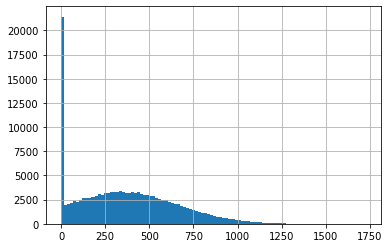

In [15]:
internet['mb_used'].hist(bins=100)

In [16]:
internet[internet['mb_used'] == 0]['mb_used'].count() * 100/ len(internet['mb_used'])

13.118155773916303

In [17]:
internet['mb_used'].isna().sum()

0

<div class="alert alert-block alert-info"> Есть большое количество сессий с нулевым трафиком - 13 процентов. Похоже это оборванные сессии - люди пытались выйти в сеть но у них не получилось.</div>

In [18]:
internet_users = internet.merge(users, on='user_id', how='outer')

In [19]:
internet_users[internet_users['mb_used'] == 0]['city'].value_counts()

Москва             3541
Санкт-Петербург    1810
Новосибирск         613
Уфа                 606
Ульяновск           596
                   ... 
Курган               30
Кемерово             12
Нижневартовск         9
Сургут                8
Иваново               6
Name: city, Length: 76, dtype: int64

<div class="alert alert-block alert-info"> Большинство оборванных сессий произошло в Москве и Петербурге, в двух самых густонаселенных городах России(http://www.statdata.ru/largest_cities_russia). Нужно посмотреть на оборванные сессии в процентном соотношении.</div>


In [20]:
(internet_users[internet_users['mb_used'] == 0]['city'].value_counts() / internet_users['city'].value_counts()).sort_values(ascending=False)

Химки            0.197917
Архангельск      0.181675
Петрозаводск     0.175730
Владикавказ      0.173028
Якутск           0.168495
                   ...   
Тольятти         0.073600
Кемерово         0.067039
Нижневартовск    0.062937
Брянск           0.059761
Сургут           0.040201
Name: city, Length: 76, dtype: float64

<div class="alert alert-block alert-info"> В таблице не прослеживается корреляции оборванных сессий и местонахождения города, Химки - пригород Москвы, Архангельск - крайний север, Владикавказ - Кавказ.</div>

In [21]:
internet_users[internet_users['mb_used'] == 0]['month'].value_counts() / internet_users['month'].value_counts()

12.0    0.133917
11.0    0.133245
10.0    0.132041
9.0     0.132138
8.0     0.129443
7.0     0.129908
6.0     0.126707
5.0     0.127445
4.0     0.125787
3.0     0.127533
2.0     0.143128
1.0     0.135184
Name: month, dtype: float64

<div class="alert alert-block alert-info"> Количество оборванных сессий не меняется относительно месяца. Возможно дело в том, что оператор быстро растет и не может обеспечить должное качество связи.</div>

In [1]:
internet_users.groupby('month')['id'].count()
#internet_users.groupby('month')['id'].count() / internet_users.groupby('month' - 1)['id'].count()

NameError: name 'internet_users' is not defined

<div class="alert alert-block alert-info"> Действительно, оператор прибавляет по несколько тысяч сессий в месяц, и за год количество сессий возрасло в 24 раза.</div>

In [23]:
# check
(
    internet_users
         .groupby('month')['user_id'].value_counts()
         .to_frame()
         .rename(columns={'user_id':'count'})
         .reset_index()
         .groupby('month')['user_id'].count()
         .to_frame()
         .rename(columns={'user_id':'count_client'})
         .reset_index()
)

,month,count_client
0,1.0,43
1,2.0,80
2,3.0,114
3,4.0,167
4,5.0,207
5,6.0,247
6,7.0,291
7,8.0,340
8,9.0,374
9,10.0,416


<div class="alert alert-block alert-info"> Окей, дело не в количестве пользователей, в последний месяц оператор получил всего 26 новых клиентов, при этом количество оборванных сессий составило 13,5%. Варианты решения проблемы: исследовать данные дальше, посоветоваться с руководством(может эти обрывы вообще не критичны, например алгоритм пытается подключиться к интернету сразу после оборванной сессии и подключается), провести исследование - насколько эти обрывы портят жизнь пользователям, и тд.</div>

### Создание сводной таблицы расходов пользователя

Создадим сводную таблицу расходов пользователя учитывающую интернет, звонки и сообщения.

In [25]:
df_internet = pd.pivot_table(internet, index=['user_id', 'month'], values='mb_used', aggfunc='sum')
df_internet

mb_used
user_id month          
1000    5       2253.49
        6      23233.77
        7      14003.64
        8      14055.93
        9      14568.91
...                 ...
1498    10     20579.36
1499    9       1845.75
        10     17788.51
        11     17963.31
        12     13055.58

[3203 rows x 1 columns]

In [26]:
calls

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0,1000,7
1,1000_1,2018-08-17,0,1000,8
2,1000_2,2018-06-11,3,1000,6
3,1000_3,2018-09-21,14,1000,9
4,1000_4,2018-12-15,6,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,1,1499,12
202603,1499_216,2018-10-18,19,1499,10
202604,1499_217,2018-11-10,11,1499,11
202605,1499_218,2018-10-06,5,1499,10


In [27]:
df_calls = pd.pivot_table(calls, index=['user_id', 'month'], values='duration', aggfunc='sum')
df_calls

duration
user_id month          
1000    5           159
        6           172
        7           340
        8           408
        9           466
...                 ...
1498    10          247
1499    9            70
        10          449
        11          612
        12          492

[3174 rows x 1 columns]

In [28]:
messages['count'] = 1

In [29]:
df_messages = pd.pivot_table(messages, index=['user_id', 'month'], values = ['count'], aggfunc='sum')
df_messages

count
user_id month       
1000    5         22
        6         60
        7         75
        8         81
        9         57
...              ...
1498    10        42
1499    9         11
        10        48
        11        59
        12        66

[2717 rows x 1 columns]

In [30]:
df_merged = df_internet.merge(df_calls, on=['user_id', 'month'], how = 'outer')
df_merged = df_merged.merge(df_messages, on=['user_id', 'month'], how = 'outer').reset_index()
df_merged = df_merged.merge(users, on=['user_id'], how = 'outer')
df_merged = df_merged.merge(tariffs, on=['tariff'], how = 'outer')
df_merged = df_merged.rename(columns={"duration": "min_used", "count": "messages"})
df_merged

,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included
0,1000,5.0,2253.49,159.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
1,1000,6.0,23233.77,172.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
2,1000,7.0,14003.64,340.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
3,1000,8.0,14055.93,408.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
4,1000,9.0,14568.91,466.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1499,9.0,1845.75,70.0,11.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0
3212,1499,10.0,17788.51,449.0,48.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0
3213,1499,11.0,17963.31,612.0,59.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0
3214,1499,12.0,13055.58,492.0,66.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0


<div class="alert alert-block alert-info"> Создали сводную таблицу, округлим значения согласно правилам оператора.</div>

In [31]:
np.ceil(df_merged[['month', 'mb_used','min_used','messages']])
df_merged['gb_used'] = np.ceil(df_merged['mb_used'] / 1024)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   mb_used                3203 non-null   float64       
 3   min_used               3174 non-null   float64       
 4   messages               2717 non-null   float64       
 5   age                    3216 non-null   int64         
 6   churn_date             189 non-null    datetime64[ns]
 7   city                   3216 non-null   object        
 8   first_name             3216 non-null   object        
 9   last_name              3216 non-null   object        
 10  reg_date               3216 non-null   datetime64[ns]
 11  tariff                 3216 non-null   object        
 12  messages_included      3216 non-null   int64         
 13  mb_

In [32]:
df_merged[['gb_used', 'mb_used']].head(3)

,gb_used,mb_used
0,3.0,2253.49
1,23.0,23233.77
2,14.0,14003.64


<div class="alert alert-block alert-info"> Посчитаем дополнительные расходы для каждого абонента</div>

In [33]:
df_merged.isna().sum()

user_id                     0
month                       2
mb_used                    13
min_used                   42
messages                  499
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
gb_used                    13
dtype: int64

<div class="alert alert-block alert-info"> Поработаем с пропусками.</div>

In [34]:
display(
    df_merged.query('month.isna()'),
    df_merged.query('mb_used.isna()'),
    df_merged.query('min_used.isna()'),
    df_merged.query('messages.isna()'),
    df_merged.query('gb_used.isna()'))

,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
985,1128,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
3215,1371,NaN,NaN,NaN,NaN,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,50,15360,500,550,200,3,3,15.0,NaN


,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
715,1377,2.0,NaN,179.0,2.0,59,NaT,Брянск,Альфред,Семин,2018-02-25,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
778,1392,2.0,NaN,13.0,3.0,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
977,1273,5.0,NaN,220.0,21.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
978,1273,6.0,NaN,230.0,38.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
979,1273,7.0,NaN,253.0,37.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
980,1273,8.0,NaN,253.0,41.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
981,1273,9.0,NaN,223.0,32.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
982,1273,10.0,NaN,315.0,35.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
983,1273,11.0,NaN,272.0,29.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
984,1273,12.0,NaN,260.0,39.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN


,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
151,1091,5.0,10703.37,NaN,30.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,11.0
152,1091,6.0,10236.19,NaN,30.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,10.0
153,1091,7.0,16444.98,NaN,35.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,17.0
154,1091,8.0,12633.88,NaN,31.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,13.0
155,1091,9.0,16597.11,NaN,32.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,17.0
156,1091,10.0,15644.73,NaN,44.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,16.0
157,1091,11.0,11864.25,NaN,28.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,12.0
158,1091,12.0,13280.45,NaN,42.0,36,NaT,Набережные Челны,Вера,Суслова,2018-05-08,ultra,1000,30720,3000,1950,150,1,1,30.0,13.0
204,1106,4.0,2923.49,NaN,9.0,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,1000,30720,3000,1950,150,1,1,30.0,3.0
205,1106,5.0,16573.01,NaN,28.0,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,1000,30720,3000,1950,150,1,1,30.0,17.0


,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
49,1024,10.0,3310.05,79.0,NaN,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,30.0,4.0
50,1024,11.0,43107.47,1146.0,NaN,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,30.0,43.0
51,1024,12.0,35948.13,949.0,NaN,73,NaT,Санкт-Петербург,Иулиан,Антипов,2018-10-31,ultra,1000,30720,3000,1950,150,1,1,30.0,36.0
67,1049,3.0,6195.54,403.0,NaN,41,NaT,Москва,Габриель,Ларин,2018-03-10,ultra,1000,30720,3000,1950,150,1,1,30.0,7.0
68,1049,4.0,5291.10,528.0,NaN,41,NaT,Москва,Габриель,Ларин,2018-03-10,ultra,1000,30720,3000,1950,150,1,1,30.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,1494,9.0,16962.51,501.0,NaN,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,50,15360,500,550,200,3,3,15.0,17.0
3189,1494,10.0,17767.24,354.0,NaN,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,50,15360,500,550,200,3,3,15.0,18.0
3190,1494,11.0,18052.45,411.0,NaN,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,50,15360,500,550,200,3,3,15.0,18.0
3191,1494,12.0,17621.21,418.0,NaN,62,NaT,Омск,Ренат,Андропов,2018-08-17,smart,50,15360,500,550,200,3,3,15.0,18.0


,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
715,1377,2.0,NaN,179.0,2.0,59,NaT,Брянск,Альфред,Семин,2018-02-25,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
778,1392,2.0,NaN,13.0,3.0,54,2018-09-27,Челябинск,Алла,Беликова,2018-02-27,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
977,1273,5.0,NaN,220.0,21.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
978,1273,6.0,NaN,230.0,38.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
979,1273,7.0,NaN,253.0,37.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
980,1273,8.0,NaN,253.0,41.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
981,1273,9.0,NaN,223.0,32.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
982,1273,10.0,NaN,315.0,35.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
983,1273,11.0,NaN,272.0,29.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN
984,1273,12.0,NaN,260.0,39.0,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,1000,30720,3000,1950,150,1,1,30.0,NaN


<div class="alert alert-block alert-info"> Пропуски в столбце месяц изза того, что дата регистрации стоит после даты отмены тарифа. Просто дропнем эти две строки.
Пропуски в столбцах mb_used, messages, min_used и gb_used похоже стоят у тех абонентов, кто вообще не пользовался данной услугой, можно их заменить на 0.</div>

In [35]:
df_merged.query('messages == 0')

,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used


<div class="alert alert-block alert-info"> Так и есть, например в столбце messages вообще нет строк где messages = 0.</div>

In [36]:
df_merged = df_merged.dropna(subset=['month']).reset_index(drop=True)

In [37]:
df_merged.loc[df_merged['mb_used'].isna(), 'mb_used'] = 0
df_merged.loc[df_merged['min_used'].isna(), 'min_used'] = 0
df_merged.loc[df_merged['messages'].isna(), 'messages'] = 0
df_merged.loc[df_merged['gb_used'].isna(), 'gb_used'] = 0
df_merged

,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used
0,1000,5.0,2253.49,159.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,3.0
1,1000,6.0,23233.77,172.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,23.0
2,1000,7.0,14003.64,340.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,14.0
3,1000,8.0,14055.93,408.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,14.0
4,1000,9.0,14568.91,466.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10.0,20579.36,247.0,42.0,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,15.0,21.0
3210,1499,9.0,1845.75,70.0,11.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0,2.0
3211,1499,10.0,17788.51,449.0,48.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0,18.0
3212,1499,11.0,17963.31,612.0,59.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0,18.0


In [38]:
df_merged.isna().sum()

user_id                     0
month                       0
mb_used                     0
min_used                    0
messages                    0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
gb_used                     0
dtype: int64

In [39]:
df_merged['min_extra'] = df_merged['min_used'] - df_merged['minutes_included']
df_merged['messages_extra'] = df_merged['messages'] - df_merged['messages_included']
df_merged['gb_extra'] = df_merged['gb_used'] - df_merged['gb_per_month_included']

df_merged.loc[df_merged['min_extra'] < 0, 'min_extra'] = 0
df_merged.loc[df_merged['messages_extra'] < 0, 'messages_extra'] = 0
df_merged.loc[df_merged['gb_extra'] < 0, 'gb_extra'] = 0

df_merged

,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used,min_extra,messages_extra,gb_extra
0,1000,5.0,2253.49,159.0,22.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,3.0,0.0,0.0,0.0
1,1000,6.0,23233.77,172.0,60.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,23.0,0.0,0.0,0.0
2,1000,7.0,14003.64,340.0,75.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,14.0,0.0,0.0,0.0
3,1000,8.0,14055.93,408.0,81.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,14.0,0.0,0.0,0.0
4,1000,9.0,14568.91,466.0,57.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,30.0,15.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,10.0,20579.36,247.0,42.0,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,50,15360,500,550,200,3,3,15.0,21.0,0.0,0.0,6.0
3210,1499,9.0,1845.75,70.0,11.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0,2.0,0.0,0.0,0.0
3211,1499,10.0,17788.51,449.0,48.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0,18.0,0.0,0.0,3.0
3212,1499,11.0,17963.31,612.0,59.0,35,NaT,Пермь,Гектор,Корнилов,2018-09-27,smart,50,15360,500,550,200,3,3,15.0,18.0,112.0,9.0,3.0


In [40]:
df_merged.isna().sum()

user_id                     0
month                       0
mb_used                     0
min_used                    0
messages                    0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
mb_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
gb_per_month_included       0
gb_used                     0
min_extra                   0
messages_extra              0
gb_extra                    0
dtype: int64

In [41]:
df_merged['total_monthly_fee'] = (df_merged['rub_monthly_fee'] + 
                                  df_merged['messages_extra'] * df_merged['rub_per_message'] +
                                  df_merged['min_extra'] * df_merged['rub_per_minute'] +
                                  df_merged['gb_extra'] * df_merged['rub_per_gb'])
df_merged.query('total_monthly_fee.isna()')

,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used,min_extra,messages_extra,gb_extra,total_monthly_fee


In [42]:
df_merged['total_monthly_fee'].sum()

4914451.0

## Анализ данных

<div class="alert alert-block alert-info"> Создадим две переменные для наших тарифов.</div>

In [43]:
ultra = df_merged[df_merged['tariff'] == 'ultra']
smart = df_merged[df_merged['tariff'] == 'smart']

### Интернет

In [44]:
ultra['gb_used'].describe()

count    985.000000
mean      19.494416
std        9.853511
min        0.000000
25%       12.000000
50%       19.000000
75%       27.000000
max       49.000000
Name: gb_used, dtype: float64

<div class="alert alert-block alert-info"> Пользователи тарифа ультра используют в среднем около 19 гб интернета в месяц.</div>

In [45]:
smart['gb_used'].describe()

count    2229.000000
mean       16.328847
std         5.747061
min         0.000000
25%        13.000000
50%        17.000000
75%        20.000000
max        38.000000
Name: gb_used, dtype: float64

<div class="alert alert-block alert-info"> Пользователи тарифа смарт используют в среднем около 17 гб интернета в месяц. Всего на  2-3 гб меньше чем средний пользователь тарифа ультра. При этом тариф смарт включает всего 15гб трафика, а тариф ультра 30гб.</div>

<AxesSubplot:>

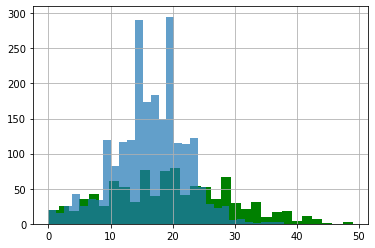

In [46]:
ultra['gb_used'].hist(bins=30, color='green')
smart['gb_used'].hist(bins=30, alpha=0.7)

<div class="alert alert-block alert-info"> Распределения нормальные в обоих тарифах. Тариф ультра имеет большую дисперсию, но при этом среднее практически совпадает с тарифом ультра. Это подтверждает наши предыдущие рассчеты.</div>

### Сообщения

In [47]:
ultra['messages'].describe()

count    985.000000
mean      49.363452
std       47.804457
min        0.000000
25%        6.000000
50%       38.000000
75%       79.000000
max      224.000000
Name: messages, dtype: float64

In [48]:
smart['messages'].describe()

count    2229.000000
mean       33.384029
std        28.227876
min         0.000000
25%        10.000000
50%        28.000000
75%        51.000000
max       143.000000
Name: messages, dtype: float64

<AxesSubplot:>

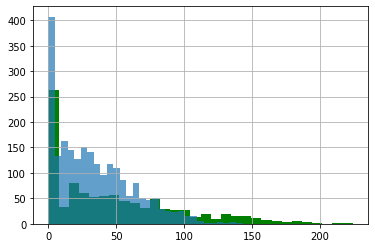

In [49]:
ultra['messages'].hist(bins=30, color='green')
smart['messages'].hist(bins=30, alpha=0.7)

<div class="alert alert-block alert-info"> Пуассоновское распределение сообщений. При этом, пользователи тарифа ультра отправляют в среднем 61 сообщений в месяц, а пользователи тарифа смарт ~39 сообщений.</div>

### Звонки

In [50]:
ultra['min_used'].describe()

count     985.000000
mean      526.623350
std       317.606098
min         0.000000
25%       284.000000
50%       518.000000
75%       752.000000
max      1673.000000
Name: min_used, dtype: float64

In [51]:
smart['min_used'].describe()

count    2229.000000
mean      417.934948
std       190.313730
min         0.000000
25%       282.000000
50%       422.000000
75%       545.000000
max      1435.000000
Name: min_used, dtype: float64

<AxesSubplot:>

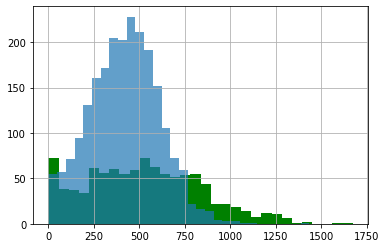

In [52]:
ultra['min_used'].hist(bins=30, color='green')
smart['min_used'].hist(bins=30, alpha=0.7)

<div class="alert alert-block alert-info"> Нормальное распределение звонков. Как и в случае с сообщениями/интернетом, пользователи тарифа ультра сильнее разнятся в количество потраченных минут.</div>

## Проверка гипотез

<div class="alert alert-block alert-info"> Перед нами стоит задача проверить две гипотезы:
    средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
    Сравнить выручку от тарифов можно по нескольким параметрам. Например, посчитать сколько приносит компании средний пользователь каждого из тарифов. К сожалению, такой подход не учитывает расходы оператора на связь, ведь пользователи тарифа смарт могут пользоваться меньшим объемом трафика чем пользователи тарифа ультра, а стоимость установки станций связи в Москве может быть дешевле чем в другом месте. Другой подход - подсчитать среднюю стоимость покупки гигабайта трафика, сообщения, минуты звонка пользователями обоих тарифов/обоих городов и сравнить их между собой. Проблема во втором подходе - в том, что мы не можем выделить какую долю стоимости тарифа занимает интернет, сообщения или звонки. Выберем первый подход и попробуем посчитать сколько денег компании в среднем приносит пользователь каждого тарифа
 </div>

In [53]:
ultra['total_monthly_fee'].mean()

2070.1522842639592

In [54]:
smart['total_monthly_fee'].mean()

1289.9735307312696

In [55]:
smart[smart['total_monthly_fee'].isna()]

,user_id,month,mb_used,min_used,messages,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_per_month_included,gb_used,min_extra,messages_extra,gb_extra,total_monthly_fee


H0 - средняя выручка от клиента тарифа ultra не отличается от средней выручки клиента тарифа smart.
H1 - средняя выручка от клиента тарифа ultra отличается от средней выручки клиента тарифа smart.


In [56]:
results = st.ttest_ind(ultra['total_monthly_fee'], smart['total_monthly_fee'], equal_var = True)

alpha = 0.05

print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


<div class="alert alert-block alert-info"> Мы отвергли нулевую гипотезу, следовательно различие в доходности не случайно с вероятностью почти 100%. Проверим различается ли выручка от клиентов из Москвы, и не из Москвы.
 </div>

In [57]:
results = st.ttest_ind(df_merged.query('city == "Москва"')['total_monthly_fee'],
                       df_merged.query('city != "Москва"')['total_monthly_fee'], 
                       equal_var = True)
alpha = 0.05
                       
print('p-значение:', results.pvalue)
                       
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


<div class="alert alert-block alert-info"> У нас не получилось отвергнуть нулевую гипотезу, следовательно с вероятностью 0,544 различие средней прибыльности клиентов из москвы и других городов случайно.
 </div>

## Общий вывод

Мы проанализировали данные сотового оператора связи «Мегалайн». Согласно полученным данным клиенты тарифа ultra используют больше сообщений, минут и трафика в месяц, чем клиенты тарифа smart. Согласно проверенным гипотезам, выручка от клиентов тарифа ultra отличается от выручки клиентов тарифа smart. В то же время, выручка клиентов из Москвы, и из других регионов практически не отличается.

In [59]:
display(
    ultra.query('month == 12')['total_monthly_fee'].describe(),
    smart.query('month == 12')['total_monthly_fee'].describe()
)

count     139.000000
mean     2138.848921
std       482.296858
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      3900.000000
Name: total_monthly_fee, dtype: float64

count     337.000000
mean     1578.531157
std      1034.735951
min       550.000000
25%       753.000000
50%      1277.000000
75%      2101.000000
max      6770.000000
Name: total_monthly_fee, dtype: float64

In [60]:
display(
    ultra.query('month == 12')['gb_used'].describe(),
    smart.query('month == 12')['gb_used'].describe()
)

count    139.000000
mean      21.741007
std       10.160550
min        0.000000
25%       15.000000
50%       22.000000
75%       28.000000
max       43.000000
Name: gb_used, dtype: float64

count    337.000000
mean      18.201780
std        5.457705
min        5.000000
25%       15.000000
50%       18.000000
75%       22.000000
max       38.000000
Name: gb_used, dtype: float64

По состоянию на декабрь 2018 года, тарифом ультра пользуются 139 человек, или 29% от всех клиентов оператора, а тарифом смарт пользуются 337 человек, или 71 процент от всех клиентов оператора. Клиенты тарифа ультра в среднем потратили около 2139 на услуги связи, а клиенты тарифа смарт в среднем потратили около 1579 рублей, на 27% меньше чем клиенты тарифа ультра. При этом, клиенты тарифа смарт, в среднем, потратили всего на 3 гигабайта, или 15% меньше интернета чем клиенты тарифа смарт. Получается, что среднему клиенту выгоднее купить тариф смарт, и докупить недостающий трафик, чем покупать тариф ультра.

In [61]:
display(
    ultra['total_monthly_fee'].sum(),
    smart['total_monthly_fee'].sum(),
    smart['total_monthly_fee'].sum() / ultra['total_monthly_fee'].sum()
)

2039100.0

2875351.0

1.410107890736109

Судя по данной выборке, тариф смарт приносит компании всего на 41 процент больше выручки чем тариф ультра.

In [62]:
display(
    ultra['gb_used'].sum(),
    smart['gb_used'].sum(),
    smart['gb_used'].sum() / ultra['gb_used'].sum()
)

19202.0

36397.0

1.8954796375377565

При этом, пользователи тарифа смарт потребляют почти в два раза больше трафика чем пользователи тарифа ультра.

<AxesSubplot:>

<AxesSubplot:>

46.83451776649746

46.55630327501122

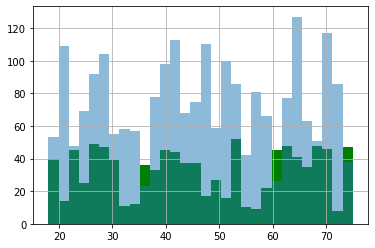

In [63]:
display(
    ultra['age'].hist(bins=30, color='green'),
    smart['age'].hist(bins=30, alpha=0.5),
    ultra['age'].mean(), smart['age'].mean()
)

Примечательно, что пользователи обоих тарифов имеют одинаковый средний возраст, и гистограммы пользователей схожи для обоих тарифов. Следовательно, можно не таргетировать рекламу по возрасту.

In [64]:
display(
    df_merged.query('city == "Москва"')['tariff'].value_counts(normalize=True),
    df_merged.query('city != "Москва"')['tariff'].value_counts(normalize=True)
)

smart    0.631751
ultra    0.368249
Name: tariff, dtype: float64

smart    0.708029
ultra    0.291971
Name: tariff, dtype: float64

В Москве больше людей, которые пользуются ультра относительно других городов. Возможно причина в том, что москвичи больше задействованы в айти/бизнесе, и им требуется больший объем трафика/сообщений/звонков.

In [65]:
display(
df_merged.query('city == "Москва"')['mb_used'].sum() / len(df_merged.query('city == "Москва"')),
df_merged.query('city != "Москва"')['mb_used'].sum() / len(df_merged.query('city != "Москва"')))

17963.873584288052

17030.096415674223

При этом различия в объеме трафика на человека между Москвой и регионами не такие значительные - всего 1 гб!